<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

<left><img width=25% src="img/cu_logo.svg"></left>

# Lecture 6: Evaluation and Regularization of Supervised Learning Models

__Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Announcement

* **Course evaluations**:
  * I got an extension for submission until this Thursday (12/4) at 11.59 pm.
  * Please, submit your evaluations.

* Reminder we have **Journal Club 2** tomorrow (Dec 4):
   * *The effect of non-linear signal in classification problems using gene expression* (on Canvas)

# Lecture feedback

**Thank you** for providing feedback!

### Summary
* Let's start taking **breaks** when we reach 45-60 min
* Virtual instructor mode &rarr; **virtual class**
* Adding "Summary sections" after each part of a lecture

# Agenda

### Part 1: Two Failure Modes of Machine Learning
- Overfitting (high variance) and underfitting (high bias)
- Polynomial regression examples

### Part 2: Regularization
- L2 regularization and Ridge regression
- L1 regularization and Lasso; sparse models and interpretability

### Part 3: A Framework for Applying Supervised Learning
- Train/validation/test splits and cross-validation
- Diagnosing and addressing overfitting/underfitting

### Part 4: Evaluating Supervised Learning Models
- Classification metrics (accuracy, precision, recall, F-score)
- ROC and Precision-Recall curves

### Hands-on Exercise
- Apply evaluation metrics to real classification problems

# Part 1: Two Failure Modes of Machine Learning

We have seen a few supervised and unsupervised learning algorithms.

Next, let's look at why they work (and why sometimes they don't).

# Review: Generalization, Underfitting and Overfitting

We can think of the data distribution as being the sum of two distinct components $$\mathbb{P} = F + E$$

1. A signal component $F$ (functional relationship, hidden clusters, low-dimensional data space, etc.)
2. A random noise component $E$

A machine learning model
1. **generalizes** if it fits the true signal $F$
2. **underfits** if it does not fully capture the true signal $F$
3. **overfits** if it learns the noise $E$

# Polynomial Regression

In 1D polynomial regression, we fit a model
$$ f_\theta(x) := \theta^\top \phi(x) = \sum_{j=0}^p \theta_j x^j $$
that is linear in $\theta$ but non-linear in $x$ because the features
$$\phi(x) = [1\; x\; \ldots\; x^p]$$
are non-linear. Using these features, we can fit any polynomial of degree $p$.

# Polynomials Fit the Data Well

When we switch from linear models to polynomials, we can better fit the data and increase the accuracy of our models.

Let's generate a synthetic dataset for this demonstration.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

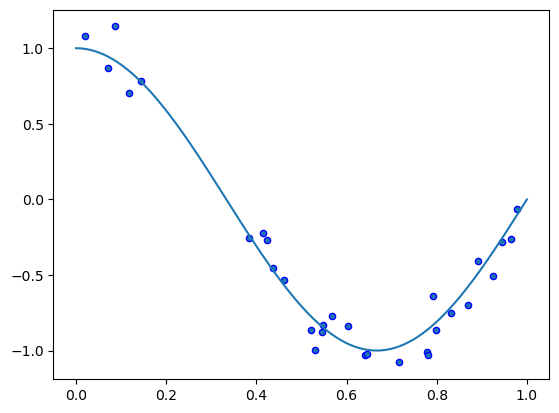

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))
true_fn = lambda X: np.cos(1.5 * np.pi * X)
y = true_fn(X) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor="b", s=20, label="Samples")

Quadratic or cubic polynomials improve the fit of a linear model.

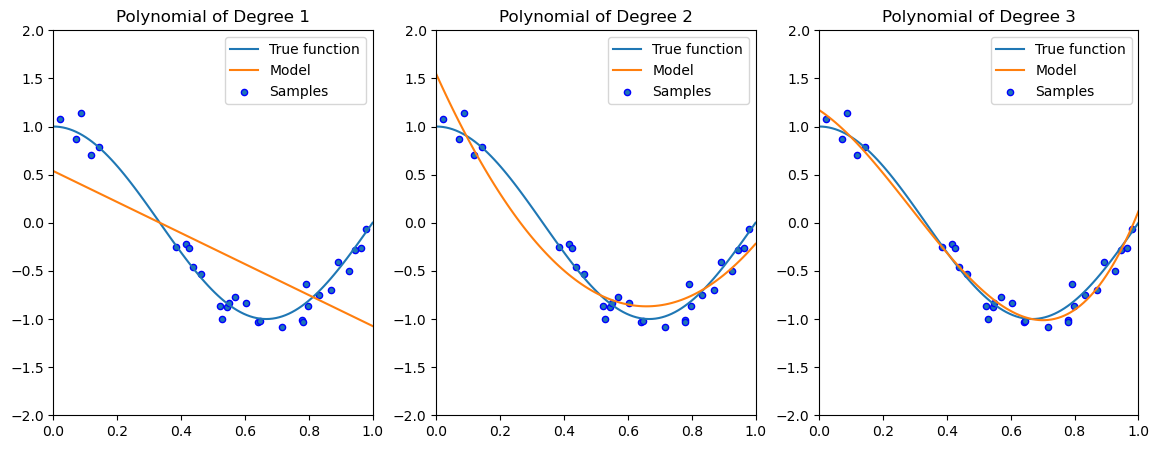

In [3]:
degrees = [1, 2, 3]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor="b", s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"Polynomial of Degree {degrees[i]}")

# Towards Higher-Degree Polynomial Features?

As we increase the complexity of our model class $\mathcal{M}$ to include even higher degree polynomials, we are able to fit the data even better.

What happens if we further increase the degree of the polynomial?

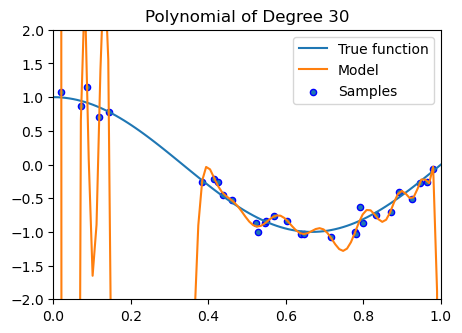

In [4]:
degrees = [30]
plt.figure(figsize=(5, 3.5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 1, 100)
    ax.plot(X_test, true_fn(X_test), label="True function")
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor="b", s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"Polynomial of Degree {degrees[i]}")

As the degree of the polynomial increases to the size of the dataset, we are increasingly able to fit every point in the dataset.

However, this results in a highly irregular curve: its behavior outside the training set is wildly inaccurate.

# Overfitting (high variance)

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (e.g., a high degree polynomial) fits the training dataset perfectly.
* But the model makes highly incorrect predictions outside this dataset, and doesn't generalize.

# Underfitting (high bias)

A related failure mode is underfitting.

* A small model (e.g., a straight line) will not fit the training data well.
* Therefore, it will also not be accurate on new data.

<!-- __Underfitting__: On one hand, if the model is too small (like the linear model in the above example), it will not generalize well to unseen data because it is not sufficiently complex to fit the true structure of the dataset.

__Overfitting__: On the other hand, if the model is too expressive (like a high degree polynomial), we are going to fit the training dataset perfectly; however, the model will make wildly incorrect prediction at points right outside this dataset, and will also not generalize well to unseen data. -->

Finding the tradeoff between overfitting and underfitting is one of the main challenges in applying machine learning.

# Overfitting vs. Underfitting: Evaluation

We can diagnose overfitting and underfitting by measuring performance on a separate holdout dataset (not used for training).
* If training performance is __high__ but holdout performance is __low__, we are overfitting.
* If training performance is __low__ and holdout performance is __low__, we are underfitting.

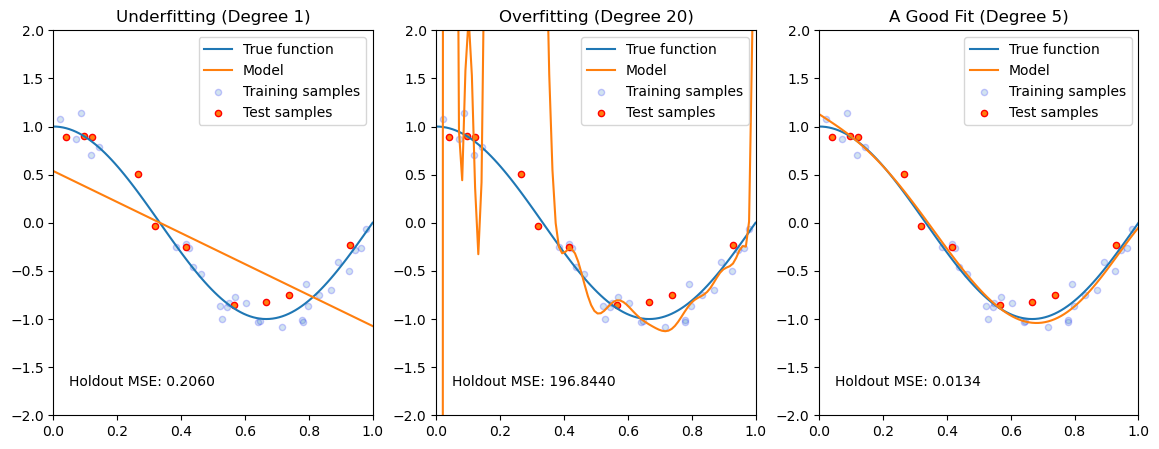

In [5]:
degrees = [1, 20, 5]
titles = ["Underfitting", "Overfitting", "A Good Fit"]
plt.figure(figsize=(14, 5))

n_holdout_samples = 30
X_holdout = np.sort(np.random.rand(n_holdout_samples))
y_holdout = true_fn(X_holdout) + np.random.randn(n_holdout_samples) * 0.1

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor="b", s=20, label="Training samples", alpha=0.2)
    ax.scatter(X_holdout[::3], y_holdout[::3], edgecolor="r", s=20, label="Test samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"{titles[i]} (Degree {degrees[i]})")
    ax.text(
        0.05,
        -1.7,
        "Holdout MSE: %.4f"
        % ((y_holdout - pipeline.predict(X_holdout[:, np.newaxis])) ** 2).mean(),
    )

# How to Fix Underfitting

What if our model doesn't fit the training set well? Try the following:
* Create richer features that will make the dataset easier to fit.
* Use a more expressive model family (higher degree polynomials).
* Try to improve your optimization algorithm.

# How to Fix Overfitting

We will see some ways of dealing with overfitting, but here are some ideas:
* Use a simpler model family (linear models vs. neural nets)
* Keep the same model, but collect more training data
* Modify the training process to penalize overly complex models.

# Summary: Part 1

* **Overfitting (high variance):** Model fits training data perfectly but fails on new data
* **Underfitting (high bias):** Model too simple to capture true signal
* **Polynomial regression:** Demonstrates the tradeoff between model complexity and generalization
* **Evaluation on holdout data:** Training error alone is insufficient; need separate test data
* **Diagnosis:**
  * Training error high → underfitting
  * Gap between training and holdout error → overfitting

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 2: Regularization

We will now see a very important way to reduce overfitting: regularization.

# Regularization: Intuition

The idea of regularization is to penalize complex models that may overfit the data.

In the previous example, a less complex model would rely less on polynomial terms of high degree.

# Regularization: Definition

The idea of regularization is to train models with an augmented objective $J : \mathcal{M} \to \mathbb{R}$ defined over a training dataset $\mathcal{D}$ of size $n$ as

$$J(f) = \underbrace{\frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f(x^{(i)}))}_\text{Learning Objective} + \underbrace{\lambda \cdot R(f)}_\text{New Regularization Term}$$

* The regularizer $R : \mathcal{M} \to \mathbb{R}$ penalizes models that are complex.

* The hyperparameter $\lambda > 0$ controls the strength of the regularizer.

# L2 Regularization: Definition

How can we define a regularizer $R: \mathcal{M} \to \mathbb{R}$ to control the complexity of a model $f \in \mathcal{M}$?

In the context of linear models $f_\theta(x) = \theta^\top x$, a widely used approach is L2 regularization, which defines the following objective:
$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \frac{\lambda}{2} \cdot ||\theta||_2^2.$$

Let's dissect the components of this objective.
$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \frac{\lambda}{2} \cdot ||\theta||_2^2.$$

* The regularizer $R : \Theta \to \mathbb{R}$ is the function
$R(\theta) = ||\theta||_2^2 = \sum_{j=1}^d \theta_j^2.$
This is also known as the L2 norm of $\theta$.

* The regularizer penalizes large parameters. This prevents us from relying on any single feature and penalizes very irregular solutions.

* L2 regularization can be used with most models (linear, neural, etc.)

Let's see an example with 6 parameters/weights (from [Google's ML course](https://developers.google.com/machine-learning/crash-course/overfitting/regularization)):

| **weight** | **value** | **squared value** |
|:---------|:-------:|:----------------:|
| $w_1$    |   0.2   | 0.04  |
| $w_2$    |   -0.5  | 0.25 |
| $w_3$    |   5.0   | 25.0     |
| $w_4$    |   -1.2  | 1.44 |
| $w_5$    |   0.3   | 0.09 |
| $w_6$    |   -0.1  | 0.01 |

- A single weight ($w_3$) contributes about 93% of the total complexity.
- The other five weights collectively contribute only about 7% of the total complexity.

L2 encourages weights toward 0, but never pushes weights all the way to zero.

[skipped] Below there is a programatic example

In [6]:
import pandas as pd
pd.set_option('display.precision', 1)

data = {
    "weight": [r"$w_1$", r"$w_2$", r"$w_3$", r"$w_4$", r"$w_5$", r"$w_6$"],
    "value": [0.2, -0.5, 5.0, -1.2, 0.3, -0.1],
}
df = pd.DataFrame(data)
df = df.assign(squared_value=df.value**2)

display(df.style.hide(axis="index").format({"value": "{:.1f}", "squared_value": "{:.1f}"}))

weight,value,squared_value
$w_1$,0.2,0.0
$w_2$,-0.5,0.2
$w_3$,5.0,25.0
$w_4$,-1.2,1.4
$w_5$,0.3,0.1
$w_6$,-0.1,0.0


# L2 Regularization for Polynomial Regression

Let's consider an application to the polynomial model we have seen so far. Given polynomial features $\phi(x)$, we optimize the following objective:

$$ J(\theta) = \frac{1}{2n} \sum_{i=1}^n \left( y^{(i)} - \theta^\top \phi(x^{(i)}) \right)^2 + \frac{\lambda}{2} \cdot ||\theta||_2^2. $$


We implement regularized and polynomial regression of degree 15 on three random training sets sampled from the same distribution.

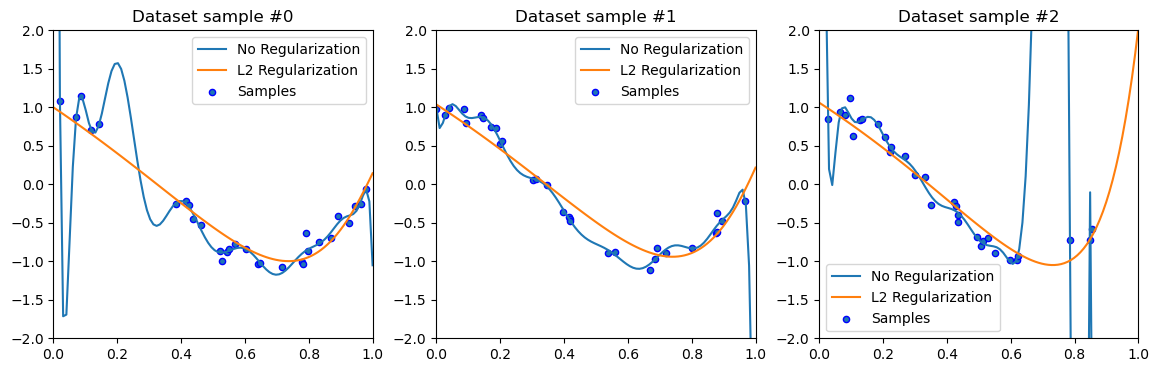

In [7]:
from sklearn.linear_model import Ridge

degrees = [15, 15, 15]
plt.figure(figsize=(14, 4))
for idx, i in enumerate(range(len(degrees))):
    # sample a dataset
    np.random.seed(idx)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = true_fn(X) + np.random.randn(n_samples) * 0.1

    # fit a least squares model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # fit a Ridge model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = Ridge(alpha=0.1)  # sklearn uses alpha instead of lambda
    pipeline2 = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline2.fit(X[:, np.newaxis], y)

    # visualize results
    ax = plt.subplot(1, len(degrees), i + 1)
    # ax.plot(X_test, true_fn(X_test), label="True function")
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="No Regularization")
    ax.plot(X_test, pipeline2.predict(X_test[:, np.newaxis]), label="L2 Regularization")
    ax.scatter(X, y, edgecolor="b", s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"Dataset sample #{idx}")

In order to define a very irregular function, we need very large polynomial weights.

Forcing the model to use small weights prevents it from learning irregular functions.

In [8]:
print(
    "Non-regularized weights of the polynomial model need to be large to fit every point:"
)
print(pipeline.named_steps["lr"].coef_[:4])
print()

print("By regularizing the weights to be small, we force the curve to be more regular:")
print(pipeline2.named_steps["lr"].coef_[:4])

Non-regularized weights of the polynomial model need to be large to fit every point:
[-3.02366436e+03  1.16527202e+05 -2.44720804e+06  3.20284526e+07]

By regularizing the weights to be small, we force the curve to be more regular:
[-2.70114811 -1.20575056 -0.09210716  0.44301292]


# How to Choose $\lambda$? Hyperparameter Search

We refer to $\lambda$ as a __hyperparameter__, because it's a high-level parameter that controls other parameters.

How do we choose $\lambda$? By splitting the data into training and validation sets (coming later).

# Algorithm: Ridge Regression

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: L2-regularized mean squared error
* __Optimizer__: Normal equations

# L1 Regularization and Sparsity

We will now look at another form of regularization, which will have an important new property called sparsity.

# L1 Regularization: Definition

Another closely related approach to regularization is to penalize the size of the weights using the L1 norm.

In the context of linear models $f(x) = \theta^\top x$, L1 regularization yields the following objective:
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \lambda \cdot ||\theta||_1. $$

Let's dissect the components of this objective.
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \lambda \cdot ||\theta||_1. $$

* The regularizer $R : \mathcal{M} \to \mathbb{R}$ is
$R(\theta) = ||\theta||_1 = \sum_{j=1}^d |\theta_j|.$
This is known as the L1 norm of $\theta$.

* This regularizer also penalizes large weights. It additionally forces most weights to decay to zero, as opposed to just being small.

# Algorithm: Lasso

L1-regularized linear regression is also known as the Lasso (least absolute shrinkage and selection operator).

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: L1-regularized mean squared error
* __Optimizer__: gradient descent, coordinate descent, least angle regression (LARS) and others

# Sparsity: Definition

A vector is said to be sparse if a large fraction of its entries is zero.

L1-regularized linear regression produces *sparse parameters* $\theta$.
* This makes the model more interpretable
* It also makes it computationally more tractable in very large dimensions.

# Sparsity: Ridge vs. Lasso

The Lasso parameters become progressively smaller, until they reach exactly zero, and then they stay at zero.

Below, we are going to visualize the parameters $\theta^*$ of Ridge and Lasso as a function of $\lambda$.

In [9]:
# based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge

X, y = load_diabetes(return_X_y=True)

# create ridge coefficients
alphas = np.logspace(
    -5,
    2,
)
ridge_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)

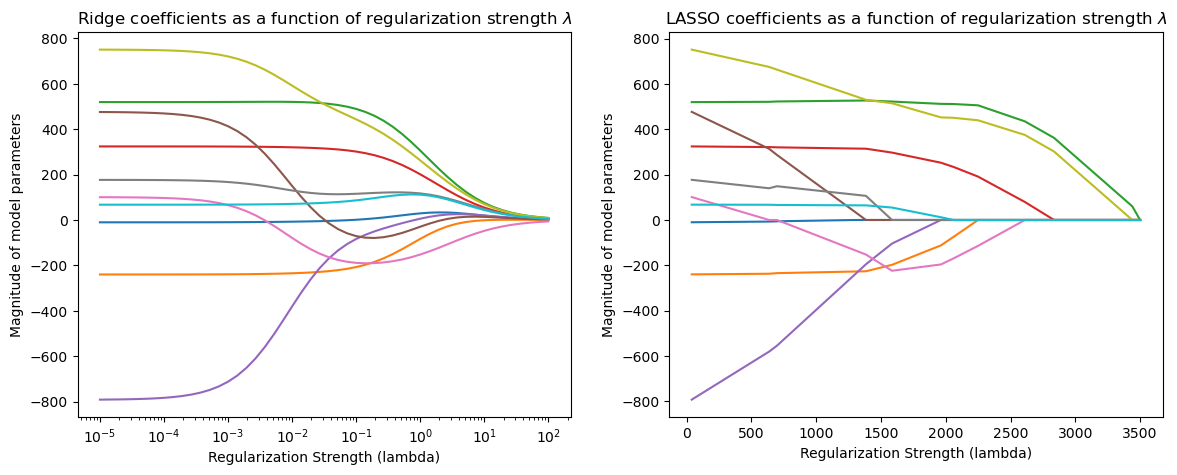

In [10]:
# Based on: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
import warnings

warnings.filterwarnings("ignore")
from sklearn.datasets import load_diabetes
from sklearn.linear_model import lars_path

# create lasso coefficients
X, y = load_diabetes(return_X_y=True)
_, _, lasso_coefs = lars_path(X, y, method="lasso")
xx = np.sum(np.abs(lasso_coefs.T), axis=1)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(alphas, ridge_coefs)
plt.xscale("log")
plt.xlabel("Regularization Strength (lambda)")
plt.ylabel("Magnitude of model parameters")
plt.title(r"Ridge coefficients as a function of regularization strength $\lambda$")
plt.axis("tight")

# plot lasso coefficients
plt.subplot(122)
plt.plot(3500 - xx, lasso_coefs.T)
ymin, ymax = plt.ylim()
plt.ylabel("Magnitude of model parameters")
plt.xlabel("Regularization Strength (lambda)")
plt.title(r"LASSO coefficients as a function of regularization strength $\lambda$")
plt.axis("tight");

# Summary: Part 2

* **Regularization:** Penalizes complex models by adding a term $\lambda \cdot R(f)$ to the objective function
* **L2 regularization (Ridge):** Uses squared norm $||\theta||_2^2$ to penalize large weights; encourages small weights but never forces them to exactly zero
* **L1 regularization (Lasso):** Uses absolute norm $||\theta||_1$ to penalize weights; forces many weights to exactly zero
* **Sparsity:** L1 produces sparse models with many zero weights, improving interpretability and computational efficiency
* **Hyperparameter $\lambda$:** Controls regularization strength; chosen via validation set or cross-validation

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 3: A Framework for Applying Supervised Learning

Next, we look at a framework for detecting and addressing over/underfitting.

# Why Do We Need A Framework for Applying Machine Learning?

It helps to be principled. Consider the following questions:
* How do we detect overfitting or underfitting?
* How to tune the degree $p$ in polynomial regression?
* How do we know that our model is ready to be deployed?

Our framework will provide answers that yield good models.

# What Is A Good Supervised Learning Model?

A good predictive model is one that makes __accurate predictions__ on __new data__ that it has not seen at training time.

* Accurate object detection in new scenes
* Correct translation of new sentences
* Accurate disease predictions in new individuals

# Datasets for Model Development

When developing machine learning models, the first step is usually to split the data into three sets:
* __Training set__: Data on which we train our algorithms.
* __Development set__ (validation or holdout set): Data used for tuning algorithms.
* __Test set__: Data used to evaluate the final performance of the model.

# Model Development Workflow

The typical way in which these datasets are used is:
1. __Training:__ Try a new model and fit it on the training set.

2. __Model Selection__: Estimate performance on the development set using metrics. Based on results, try a new model idea in step #1.

3. __Evaluation__: Finally, estimate real-world performance on test set.

# How to Use Validation Set

There are many ways to tune a model at step #2:

* Increase/decrease degree of polynomial based on over/underfitting.

* Perform grid search to find best hyper-parameter $p$.

* Understand which features to add to the model.

# Validation and Test Sets

These holdout sets are used to estimate real-world performance. How should one choose the development and test set?

__Distributional Consistency__: The development and test sets should be from the data distribution we will see in production.

__Dataset Size__: Should be large enough to estimate future performance: 30% of the data on small tasks, usually up to not more than a few thousand instances.

# Cross-Validation

If we don't have enough data for a validation set, we can do $K$-fold cross-validation.

<center><img width=70% src="img/kfold_cv.png"></center>

We group the data into $K$ disjoint folds. We train the model $K$ times, each time using a different fold for validation, and the rest for training.

# Diagnosing Underfitting and Overfitting

We may use this observation to diagnose bias/variance in practice.
* If the training error is high, we are underfitting (high bias).
* If validation error is higher than training error, we are overfitting (high variance).

Consider the following example:
* Our __training set__ error is 15%.
* Our __validation set__ error is 16%.
* __Human__ error is 2%.

This is a typical example of __high bias__ (underfitting).

Next, consider another example:
* Our __training set__ error is 4%.
* Our __validation set__ error is 12%.
* __Human__ error is 2%.

This is an example of __high variance__ (overfitting).

Finally, suppose you see the following:
* Our __training set__ error is 2.5%.
* Our __validation set__ error is 3%.
* __Human__ error is 2%.

This is a model that seems to work quite well.

# Summary: Part 3

* **Train/validation/test split:** Divide data into three sets for training, model selection/tuning, and final evaluation
* **Model development workflow:** Iterative process of training on training set, tuning on validation set, and final testing on test set
* **Cross-validation:** K-fold CV enables model evaluation when validation data is limited by training K times on different fold combinations
* **Diagnosing with error patterns:** High training error indicates underfitting; large gap between training and validation error indicates overfitting
* **Distributional consistency:** Validation and test sets must match the production data distribution for accurate performance estimates

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 4: Evaluating Supervised Learning Models

Machine learning algorithms can sometimes fail. How do we assess their performance in a principled way?

# When Do We Get Good Performance on Holdout Data?

Suppose you have a classification model trained on images of cats and dogs. On which dataset will it perform better?

* A dataset of German shepherds and Siamese cats?
* A dataset of birds and reptiles?

Clearly the former. Intuitively, ML models are accurate on new data if it is similar to the training data.

# Data Distribution

It is standard to assume that data is sampled from a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We  denote this as

$$x, y \sim \mathbb{P} \;\;\;\text{ or }\;\;\; \mathcal{D} \sim \mathbb{P}.$$

The training set $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$ consists of *independent and identically distributed* (IID) samples from $\mathbb{P}$.

# Data Distribution: IID Sampling

The key assumption is that the training examples are *independent and identically distributed* (IID).
* Each training example is from the same distribution.
* This distribution doesn't depend on previous training examples.

__Example__: Flipping a coin. Each flip has the same probability of heads & tails and doesn't depend on previous flips.

__Counter-Example__: Yearly census data. The population in each year will be close to that of the previous year.

# Holdout Dataset

A holdout set

$$\dot{\mathcal{D}} = \{(\dot{x}^{(i)}, \dot{y}^{(i)}) \mid i = 1,2,...,m\}$$

is sampled IID from the same distribution $\mathbb{P}$, and is distinct from the training dataset $\mathcal{D}$.

Let's generate a holdout dataset for the example we saw earlier.

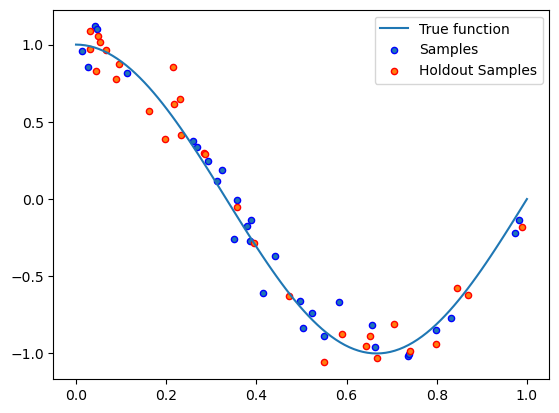

In [11]:
n_samples, n_holdout_samples = 30, 30

X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1
X_holdout = np.sort(np.random.rand(n_holdout_samples))
y_holdout = true_fn(X_holdout) + np.random.randn(n_holdout_samples) * 0.1

plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
plt.scatter(X_holdout, y_holdout, edgecolor="r", s=20, label="Holdout Samples")
plt.legend()

# Performance on a Holdout Set

Intuitively, a supervised model $f_\theta$ is "good" if it performs well on a holdout set $\dot{\mathcal{D}}$ according to some measure

$$
\frac{1}{m} \sum_{i=1}^m L\left(\dot y^{(i)}, f_\theta(\dot x^{(i)}) \right).
$$

Here, $L : \mathcal{X}\times\mathcal{Y} \to \mathbb{R}$ is a performance metric or a loss function that we get to choose.

The choice of the performance metric $L$ depends on the specific problem and our goals:

* In classification, $L$ is often just accuracy: is $\dot y^{(i)} = f_\theta(\dot x^{(i)})$?
* $L$ can also implement other metrics: $R^2$ metric (see Homework 1) for regression, etc.

# Review: Classification vs Regression

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between two types of supervised learning problems depending on the targets $y^{(i)}$.

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Classification__: The target variable $y$ is discrete, and takes on one of $K$ possible values.

When classification labels take $K=2$ values, we perform __binary classification__.

An example of a classification task is the Iris flower dataset.

In [12]:
# import standard machine learning libraries
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()  # load the Iris dataset
X, y = (
    iris.data[:120, :2],
    iris.target[:120],
)  # create imbalanced classes and only use first 2 features
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=50, random_state=0)

We may visualize this dataset in 2D.

Text(0.5, 0, 'Sepal length (cm)')

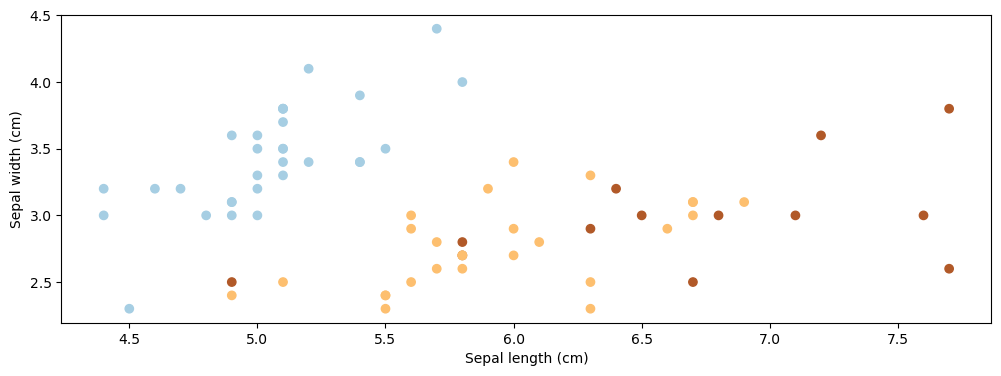

In [13]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [12, 4]

# Visualize the Iris flower dataset
setosa_flowers = iris.target == 0
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.ylabel("Sepal width (cm)")
plt.xlabel("Sepal length (cm)")

Below, we fit a Logistic Regression model to the Iris dataset.

In [14]:
from sklearn.linear_model import LogisticRegression

# fit a softmax regression model (implemented in LogisticRegression in sklearn)
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X_holdout)

# Classification Accuracy

The simplest and most natural metric for classification algorithms on a dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$ is accuracy:
$$\text{acc}(f) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{f(x^{(i)}) = y^{(i)}\},$$
where $\mathbb{I}\{\cdot\}$ is an indicator function (equals 1 if its input is true and zero otherwise).

In [15]:
accuracy = (y_pred == y_holdout).mean()
print("Iris holdout set accuracy: %.2f" % accuracy)

Iris holdout set accuracy: 0.84


# Confusion Matrix

We can better understand classification error via a confusion matrix.
* On the y-axis we have the true classes $y_j$.
* On the x-axis we have the predicted classes $\hat y_k$.
* The cell for $(y_j, \hat y_k)$ contains the number of samples of class $y_j$ that have been classified as $\hat y_k$.

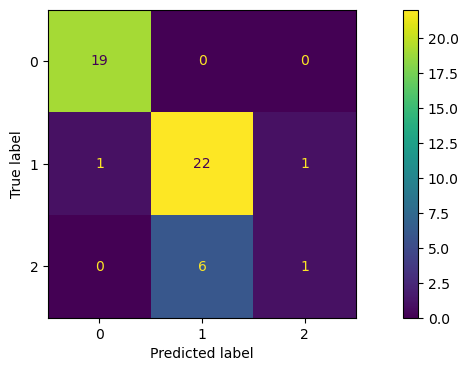

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_holdout, y_holdout)

Accuracy is a problematic metric when classes are imbalanced.

It is easy to achieve high accuracy just by being accurate on the more frequent class (by always predicting it, for example).

# Metrics for Binary Classification

We can look at performance in a more precise way when we do binary classification. Consider the following confusion matrix.

$ $                   | Predicted positive $\hat y=1$ | Predicted negative $\hat y=0$
---------------------|--------------------------------|------------------------------
Positive class $y=1$ | True positive (TP)             | False negative (FN)
Negative class $y=0$ | False positive (FP)            | True negative (TN)

We can define accuracy as follows:

$$\text{accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{FN} + \text{TN}}$$

This is the number of correct predictions divided by the total number of predictions.

# Sensitivity and Specificity

$ $                   | Predicted positive $\hat y=1$ | Predicted negative $\hat y=0$
---------------------|--------------------------------|------------------------------
Positive class $y=1$ | True positive (TP)             | False negative (FN)
Negative class $y=0$ | False positive (FP)            | True negative (TN)

We can also look at "accuracy" on each class separately. This reveals problems with imbalanced classes.
\begin{align*}
\underset{\text{(recall, true positive rate)}}{\text{sensitivity}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}} \\
\underset{\text{(true negative rate)}}{\text{specificity}} & = \frac{\text{TN}}{\text{negative class}} = \frac{\text{TN}}{\text{TN} + \text{FP}} \\
\end{align*}

We can combine these into a single measure called balanced accuracy

\begin{align*}
\text{balanced accuracy} & = \frac{1}{2}\left(\text{specificity} + \text{sensitivity}\right) \\
& = \frac{1}{2}\left(\frac{\text{TN}}{\text{TN} + \text{FP}} + \frac{\text{TP}}{\text{TP} + \text{FN}}\right)
\end{align*}

# Precision and Recall

$ $                   | Predicted positive $\hat y=1$ | Predicted negative $\hat y=0$
---------------------|--------------------------------|------------------------------
Positive class $y=1$ | True positive (TP)             | False negative (FN)
Negative class $y=0$ | False positive (FP)            | True negative (TN)

An alternative set of measures is precision and recall.
\begin{align*}
\underset{\text{(positive predictive value)}}{\text{precision}} & = \frac{\text{TP}}{\text{predicted positive}} = \frac{\text{TP}}{\text{TP} + \text{FP}} \\
\underset{\text{(sensitivity, true positive rate)}}{\text{recall}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{align*}

Imagine we are building a search engine. The positive examples are the pages that are relevant to the users.
* Precision: of the web pages returned by the engine, how many were truly relevant?
* Recall: how many relevant pages did we find?

Notice that we don't directly report performance on negatives (what % of irrelevant pages were labeled as such).

When do we choose precision and recall vs. sensitivity and specificity?
* Precision and recall are useful if we don't care about true negatives (e.g., a search engine). We only care about identifying correct positives and not missing any.

* Sensitivity and specificity are useful if negatives are also important (e.g., accurately detecting absence of cancer is also important).

# F-Score

The F-Score is the harmonic mean of precision and recall.
$$\text{F-Score} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

It equals one for perfect precision and recall and zero if one of precision or recall is zero.

# Review: Sensitivity and Specificity

$ $                   | Predicted positive $\hat y=1$ | Predicted negative $\hat y=0$
---------------------|--------------------------------|------------------------------
Positive class $y=1$ | True positive (TP)             | False negative (FN)
Negative class $y=0$ | False positive (FP)            | True negative (TN)

We can also look at "accuracy" on each class separately. This reveals problems with imbalanced classes.
\begin{align*}
\underset{\text{(recall, true positive rate)}}{\text{sensitivity}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}} \\
\underset{\text{(true negative rate)}}{\text{specificity}} & = \frac{\text{TN}}{\text{negative class}} = \frac{\text{TN}}{\text{TN} + \text{FP}} \\
\end{align*}

# Trading Off Sensitivity vs. Specificity

Suppose that true positives are more important than true negatives.
* We may output the positive class only on very confident examples.
* This will increase performance on positive examples and decrease performance on negative examples.

Most classifiers come with confidence scores that make this easy to do.

With our Logistic Regression model, we can easily obtain the class probabilities.

The default threshold for predicting class 1 in binary classification is when it has >50% probability. But we can set it higher or lower. See how we use the `predict_proba` function of the estimator:

In [17]:
pred_probabilities = model.predict_proba(X_holdout)
print("Predicted probabilities of class 1 from the model:")
print(pred_probabilities[:10, 0])

Predicted probabilities of class 1 from the model:
[0.90501497 0.16279519 0.26248867 0.91897349 0.05453355 0.98241433
 0.90443544 0.87545066 0.83223386 0.12414328]


Using `predict_proba` we can see the probabilities of all classes:

In [18]:
pred_probabilities = model.predict_proba(X_holdout)
print("Predicted probabilities for all classes from the model:")
print(pred_probabilities[-10:, :])

Predicted probabilities for all classes from the model:
[[0.02902781 0.56282889 0.40814329]
 [0.46490478 0.43655367 0.09854154]
 [0.16131279 0.70947949 0.12920772]
 [0.32438234 0.52820372 0.14741394]
 [0.8763602  0.09715341 0.0264864 ]
 [0.78777347 0.1335232  0.07870333]
 [0.16358644 0.66154276 0.1748708 ]
 [0.94432049 0.04781004 0.00786947]
 [0.01301084 0.80596299 0.18102617]
 [0.05532698 0.67280445 0.27186856]]


# Receiver Operating Characteristic (ROC)

In binary classification, the Receiver Operating Characteristic (ROC) curve plots the true positive rate and the false positive rate (FPR) as we vary the threshold for labeling a positive example.

\begin{align*}
\text{TPR} = \underset{\text{(recall, sensitivity)}}{\text{true positive rate}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}} \\
\text{FPR} = 1-\underset{\text{(true negative rate)}}{\text{specificity}} & = 1 - \frac{\text{TN}}{\text{negative class}} = \frac{\text{FP}}{\text{FP} + \text{TN}} \\
\end{align*}

Suppose we want to improve sensitivity for Class 2 on the Iris dataset.
We first compute the probability $p(y=2|x)$ for each input $x$. For any threshold $t>0$, we label $x$ as Class 2 if $p(y=2|x)>t$.
* Small $t$ result in a high TPR (we identify all positives) and high FPR (many are false).
* High $t$ result in a low TPR (we identify few positives) and low FPR (we only label the most confident inputs).

Below, the ROC curve measures the TPR and FPR as we vary $t$.

In [19]:
from sklearn.metrics import roc_curve

class2_scores = pred_probabilities[:, 2]  # we take class 2 as the "positive" class
# create labels where class 2 is the "positive" class
class2_y = np.zeros(y_holdout.shape)
class2_y[y_holdout == 2] = 1
print("First class 2 scores: ", class2_scores[:4])
fpr, tpr, thresholds = roc_curve(class2_y, class2_scores)

First class 2 scores:  [0.02493063 0.15063864 0.17466461 0.00544962]


We can visualize the TPR vs. the FPR at various thresholds.

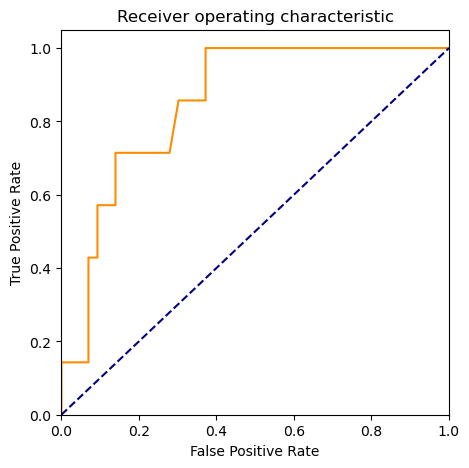

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic");

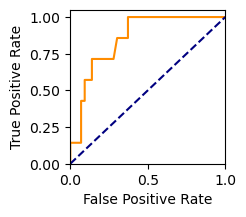

In [21]:
plt.figure(figsize=(2, 2))
plt.plot(fpr, tpr, color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");
# plt.title("Receiver operating characteristic");

\begin{align*}
\text{TPR} = \underset{\text{(recall, sensitivity)}}{\text{true positive rate}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}} \\
\text{FPR} = 1-\underset{\text{(true negative rate)}}{\text{specificity}} & = 1 - \frac{\text{TN}}{\text{negative class}} = \frac{\text{FP}}{\text{FP} + \text{TN}} \\
\end{align*}

We highlight the following properties of the ROC curve:
* In the bottom left corner, we predict only negatives. TPR = FPR = 0.
* In the top right corner, we predict only positives. TPR = FPR = 1.
* The ideal classifier is in the top left: TPR = 1, FPR = 0.
* The blue diagonal corresponds to randomly guessing "positive" with $p = \text{TPR}$.
* The ROC curve lies between ideal and random.

# Area Under the Curve

We can use the area under the curve (AUC) as a single measure of classifier performance.
* The ideal classifier (ROC curve reaches top left corner) has an AUC-ROC of one.
* A random classifier (diagonal dashed line) has an AUC-ROC of 0.5.

The AUC is the probability that a classifier will rank a random positive case higher than a random negative one.

We may compute the AUC of the above ROC curve as follows.

In [22]:
from sklearn.metrics import auc

print("AUC-ROC: %.4f" % auc(fpr, tpr))

AUC-ROC: 0.8522


# Area Under the Precision-Recall (AUC-PR)

Similar as AUC-ROC, but especially important for imbalanced datasets.

See [scikit-learn's guide](https://scikit-learn.org/stable/model_selection.html) on model selection.

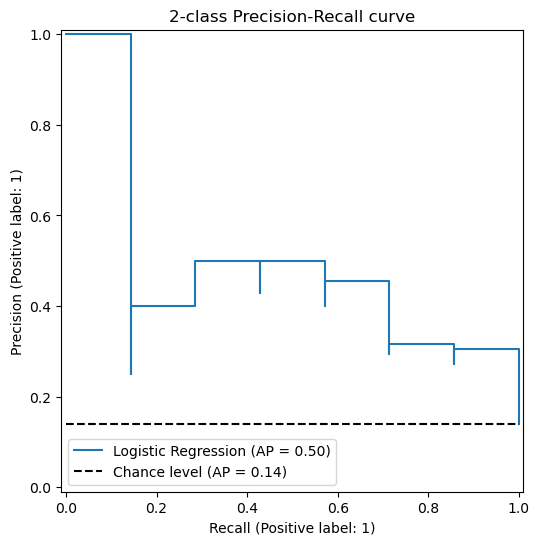

In [23]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(6, 6))
display = PrecisionRecallDisplay.from_predictions(
    class2_y,
    class2_scores,
    name="Logistic Regression",
    plot_chance_level=True,
    ax=ax,
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

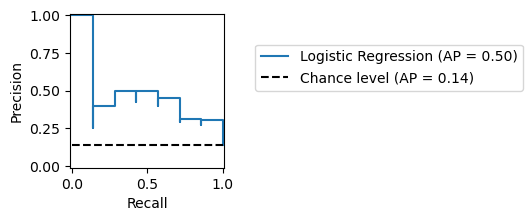

In [24]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(2, 2))
display = PrecisionRecallDisplay.from_predictions(
    class2_y,
    class2_scores,
    name="Logistic Regression",
    plot_chance_level=True,
    pos_label=None,
    ax=ax,
)
ax.legend(loc=(1.2, 0.5))
_ = display.ax_.set_ylabel("Precision")
_ = display.ax_.set_xlabel("Recall")
# _ = display.ax_.set_title("2-class Precision-Recall curve")

\begin{align*}
\underset{\text{(positive predictive value)}}{\text{precision}} & = \frac{\text{TP}}{\text{predicted positive}} = \frac{\text{TP}}{\text{TP} + \text{FP}} \\
\underset{\text{(sensitivity, true positive rate)}}{\text{recall}} & = \frac{\text{TP}}{\text{positive class}}  = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{align*}

We highlight the following properties of the PR curve:
* Plots the Precision vs. Recall as classification threshold varies.
* Baseline ("chance level" / random) precision equals the positive class prevalence.
* Curves above the baseline indicate performance better than random.
* Ideal classifier reaches Recall = Precision = 1 (top-right corner).
* Usually more informative (than ROC-AUC) when _positive_ cases are rare (imbalanced datasets).

# Summary: Part 4

* **Classification metrics:** Accuracy can be misleading with imbalanced classes; confusion matrix reveals per-class performance
* **Precision and recall:** Precision measures correctness of positive predictions; recall measures completeness of finding positives
* **Sensitivity and specificity:** Sensitivity (TPR) measures true positive rate; specificity (TNR) measures true negative rate
* **ROC and AUC-ROC:** ROC curve plots TPR vs FPR at varying thresholds; AUC summarizes overall classifier performance (1.0 = perfect, 0.5 = random)
* **Precision-Recall curves:** More informative than ROC for imbalanced datasets where positive class is rare

# **Hands-on**: Evaluating supervised models

* Open file `lecture06-hands_on-solved.ipynb` and follow the instructions there.

# Anonymous Feedback On This Lecture

<center>
    <img width=60% src="img/feedback_form_qr.png">
</center>

* **Link:** https://forms.office.com/r/prXY35CNuz
* **Lecture number:** 6
* **Lecture topic:** model evaluation